In [ ]:
import torch
import torchvision
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import shutil
sns.set()
import cv2
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Microsoft/yolov5

/content/drive/My Drive/Colab Notebooks/Microsoft/yolov5


In [ ]:
!python detect.py --save-txt --source '/content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test' --weights '/content/drive/My Drive/Colab Notebooks/Microsoft/YoloV5_weights/best_yolo_bike_detection.pt' --conf 0.7



Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.7, device='', fourcc='mp4v', img_size=640, iou_thres=0.5, output='inference/output', save_txt=True, source='/content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test', view_img=False, weights='/content/drive/My Drive/Colab Notebooks/Microsoft/YoloV5_weights/best_yolo_bike_detection.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

image 1/27 /content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test/frame0329_leftImg8bit.jpg: 384x640 1 bikes, Done. (0.042s)
image 2/27 /content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test/frame0401_leftImg8bit.jpg: 384x640 2 bikes, Done. (0.032s)
image 3/27 /content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test/frame1090_leftImg8bit.jpg: 384x640 Done. (0.031s)
image 4/27 /content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test/frame1513_leftImg8bit.jpg: 384x640 1 bikes, Done. (0.033s)
image 5/27 /content/drive/My Drive/C

Cropping the files into individual images after detection

In [ ]:
# cd /content/drive/My Drive/Colab Notebooks/Microsoft/yolov5/inference/output

In [ ]:
files = glob.glob('/content/drive/My Drive/Colab Notebooks/Microsoft/Classification/Cropped_test_images/Images/*')
for f in files:
    os.remove(f)

In [ ]:
from PIL import Image

filepath = r"/content/drive/My Drive/Colab Notebooks/Microsoft/yolov5/inference/output"
for filename in os.listdir(filepath):
    if filename.endswith(".txt"): 


         imgname = filename.replace(".txt","")
         text_file = open(filepath + "/" + filename)
         text_file = text_file.read().split('\n')


         image_file = Image.open("/content/drive/My Drive/Colab Notebooks/Microsoft/Images/Test"+ "/" + imgname + ".jpg")
         width, height = image_file.size
         desired_size = max(width,height)
         old_size = image_file.size
         ratio = float(desired_size)/max(old_size)
         new_size = tuple([int(x*ratio) for x in old_size])

         new_im = Image.new("RGB", (desired_size, desired_size))
         new_im.paste(image_file, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
         

         for n,i in enumerate(text_file):
           if len(i)>5:
            boxes = i.split()[1:]
            boxes = [float(j) for j in boxes]
            temp_crop = new_im.crop(( ((boxes[0]-boxes[2]/2)  * desired_size), ((boxes[1]-boxes[3]/2))*1.2 * desired_size  ,  (boxes[0]+boxes[2]/2) * desired_size , ((boxes[1]+boxes[3]/2))*0.9* desired_size))
            temp_crop.save("/content/drive/My Drive/Colab Notebooks/Microsoft/Classification/Cropped_test_images/Images/"+str(imgname)+ "_" + str(n) + ".jpg")


Once the detected bikes have been cropped using the generated text files, they will be passed through the efficientnet classifier as shown below

In [ ]:
!pip install efficientnet


In [ ]:
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras import applications
from efficientnet.tfkeras import EfficientNetB0
from keras import callbacks
from keras.models import Sequential

efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=True,
    pooling='max'
)

model = Sequential()
model.add(Conv2D(3, kernel_size=7, activation='relu', input_shape=(32,32,3)))
model.add(Dropout(0.4))
model.add(Conv2D(2, kernel_size=5, activation='relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.add(Dropout(0.4))

model.add(Dense(units = 1, activation='sigmoid'))
model.load_weights(r"/content/drive/My Drive/Colab Notebooks/Microsoft/Classification/ModelWeights/model.h5")

In [ ]:
test_dir = '/content/drive/My Drive/Colab Notebooks/Microsoft/Classification/Cropped_test_images'
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 41 images belonging to 1 classes.


In [ ]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'id': image_ids, 'no_helmet':predictions} 
submission = pd.DataFrame(data)
print(submission.head(10))

                            id  no_helmet
0  frame0329_leftImg8bit_0.jpg   0.904619
1  frame0401_leftImg8bit_0.jpg   0.385776
2  frame0401_leftImg8bit_1.jpg   0.890622
3  frame1513_leftImg8bit_0.jpg   0.472440
4  frame1542_leftImg8bit_0.jpg   0.531217
5  frame1542_leftImg8bit_1.jpg   0.473496
6  frame1595_leftImg8bit_0.jpg   0.721693
7  frame1595_leftImg8bit_1.jpg   0.775778
8  frame1632_leftImg8bit_0.jpg   0.766585
9  frame1632_leftImg8bit_1.jpg   0.902921


In [ ]:
# submission.to_csv("submission.csv", index=False)

In [ ]:
submission = submission[submission["no_helmet"] > 0.9]

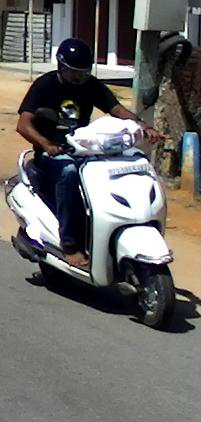

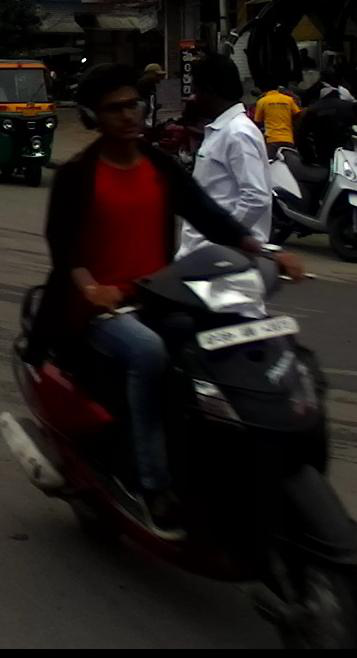

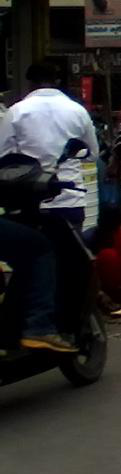

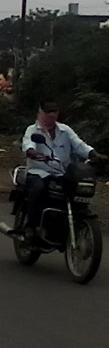

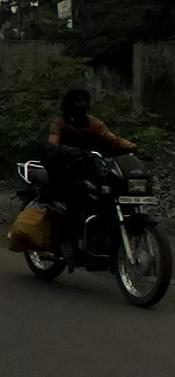

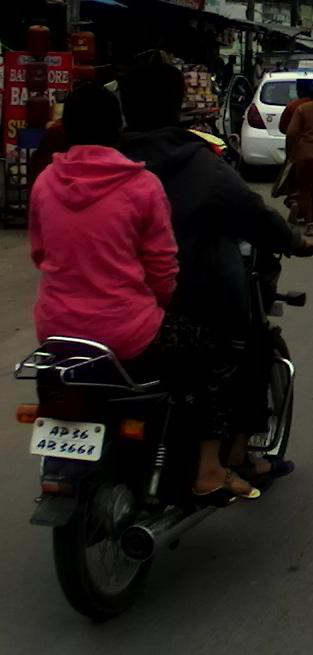

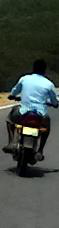

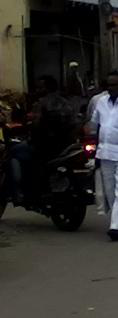

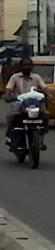

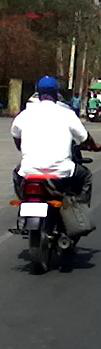

In [ ]:
for i in submission["id"]:
      image_file = Image.open("/content/drive/My Drive/Colab Notebooks/Microsoft/Classification/Cropped_test_images/Images/" + str(i))
      display(image_file)
